<a href="https://www.kaggle.com/code/faressayah/chest-x-ray-medical-diagnosis-with-cnn-densenet?scriptVersionId=117872268" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🩺 AI for Medicine Course By Deeplearning.ai

> Computer Vision (CV) has a lot of applications in medical diagnosis:
> - Dermatology
> - Ophthakmology
> - Histopathology.

> X-rays images are critical for the detection of lung cancer, pneumenia ... In this notebook you will learn:
> - Data pre-processing 
> - Preprocess images properly for the train, validation and test sets.
> - Set-up a pre-trained neural network to make disease predictions on chest X-rays.

> In this notebook you will work with chest X-ray images taken from the public [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315). 

# 📥 Import Packages and Functions

> We'll make use of the following packages:
> - `numpy` and `pandas` is what we'll use to manipulate our data
> - `matplotlib.pyplot` and `seaborn` will be used to produce plots for visualization
> - `util` will provide the locally defined utility functions that have been provided for this assignment

> We will also use several modules from the `keras` framework for building deep learning models.

> Run the next cell to import all the necessary packages.

In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import (
    Dense, Conv2D, MaxPool2D, Dropout, Flatten, 
    BatchNormalization, GlobalAveragePooling2D
)

from keras.applications.densenet import DenseNet121
from keras import backend as K

from sklearn.metrics import confusion_matrix, classification_report

os.listdir("../input/chest-xray-pneumonia/chest_xray")

['chest_xray', '__MACOSX', 'val', 'test', 'train']

In [2]:
len(os.listdir("../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"))

3875

> The dataset is divided into three sets: 
> 1. Train set 
> 2. Validation set and 
> 3. Test set. 

# 📉 Data Visualization

Train set:
PNEUMONIA=3875
NORMAL=1341
Test set:
PNEUMONIA = 390
NORMAL = 234
Validation set:
PNEUMONIA = 8
NORMAL = 8


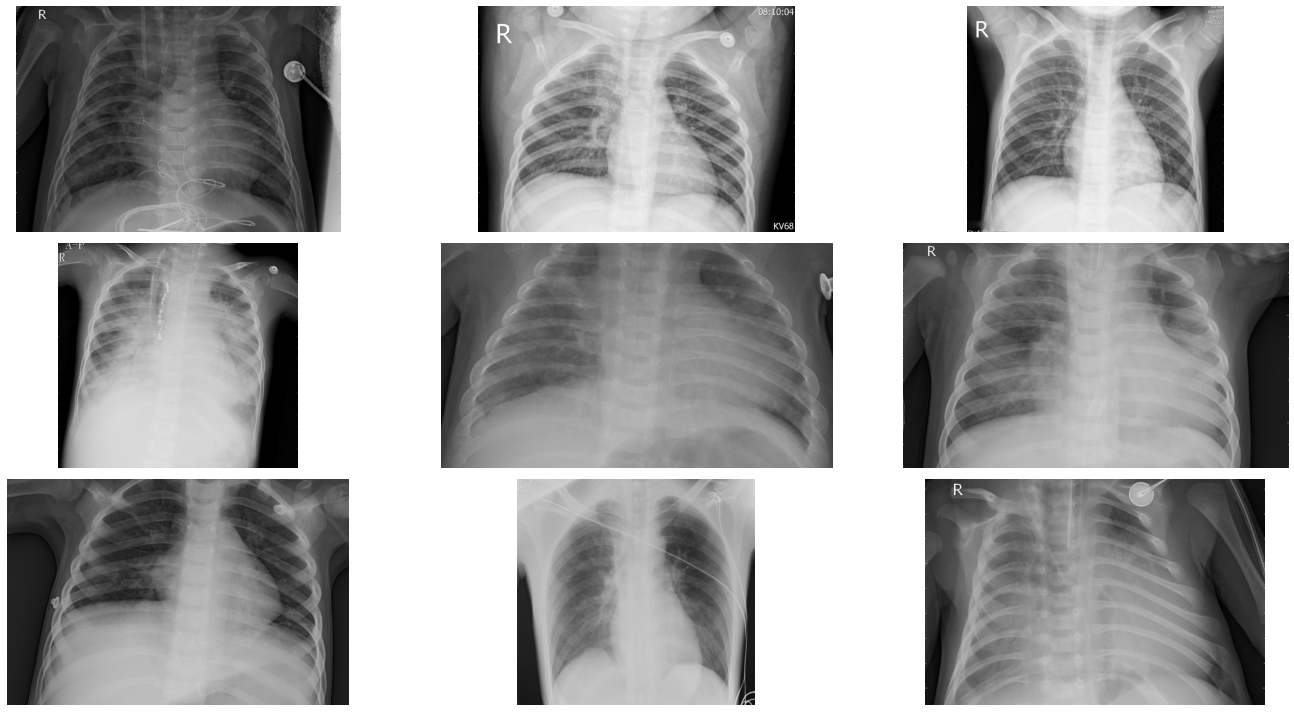

In [3]:
train_dir = "../input/chest-xray-pneumonia/chest_xray/train"
test_dir = "../input/chest-xray-pneumonia/chest_xray/test"
val_dir = "../input/chest-xray-pneumonia/chest_xray/val"

print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("Test set:\n========================================")
print(f"PNEUMONIA = {len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL = {len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("Validation set:\n========================================")
print(f"PNEUMONIA = {len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL = {len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

pneumonia = os.listdir("../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA")
pneumonia_dir = "../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

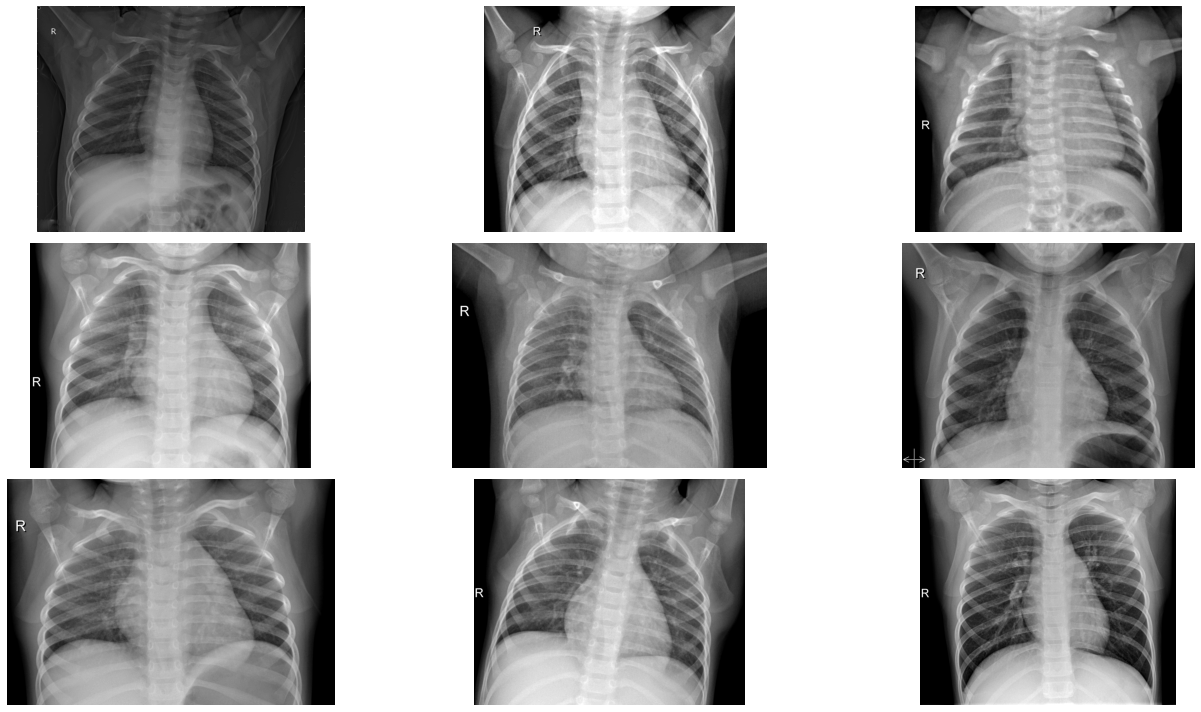

In [4]:
normal = os.listdir("../input/chest-xray-pneumonia/chest_xray/train/NORMAL")
normal_dir = "../input/chest-xray-pneumonia/chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

# 🔍 Investigate a single image

The dimensions of the image are 1128 pixels width and 1336 pixels height, one single color channel.
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 73.2978 and the standard deviation is 38.1653


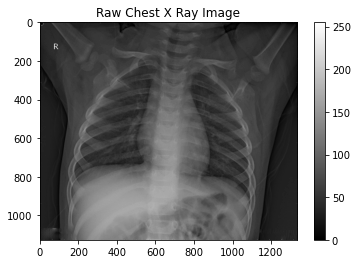

In [5]:
normal_img = os.listdir("../input/chest-xray-pneumonia/chest_xray/train/NORMAL")[0]
normal_dir = "../input/chest-xray-pneumonia/chest_xray/train/NORMAL"

sample_img = plt.imread(os.path.join(normal_dir, normal_img))
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, one single color channel.")
print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")

# 🔍 Ivestigate pixel value distribution

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# Pixels in Image')

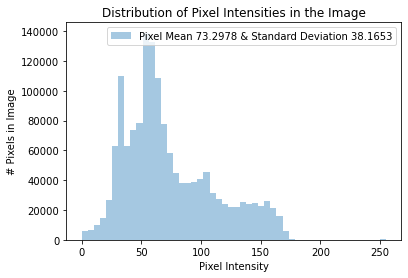

In [6]:
sns.distplot(sample_img.ravel(),
             label=f"Pixel Mean {np.mean(sample_img):.4f} & Standard Deviation {np.std(sample_img):.4f}", 
             kde=False)
plt.legend(loc='upper right')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

# 🔄 Image Preprocessing

> Before training, you'll first modify your images to be better suited for training a convolutional neural network. For this task, you'll use the Keras `ImageDataGenerator` function to perform data preprocessing and data augmentation.

> - This class also provides support for basic data augmentation such as random horizontal flipping of images.
> - We also use the generator to transform the values in each batch so that their mean is 0 and their standard deviation is 1 (this will facilitate model training by standardizing the input distribution).
> - The generator also converts our single-channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels (we will want this because the pre-trained model that we'll use requires three-channel inputs).



In [7]:
image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

✔️ **Build a separate generator for valid and test sets**

> Now we need to build a new generator for validation and testing data.

✔️ **Why can't use the same generator for the training data?**

> Look back at the generator we wrote for the training data.
> - It normalizes each image per batch, meaning that it uses batch statistics.
> - We should not do this with the test and validation data, since in a real-life scenario we don't process incoming images a batch at a time (we process one image at a time).
> - Knowing the average per batch of test data would effectively give our model an advantage (The model should not have any information about the test data).

> What we need to do is to normalize incoming test data using the statistics computed from the training set.

In [8]:
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(320, 320))

validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size=(320, 320))

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=(320, 320))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


The dimensions of the image are 320 pixels width and 320 pixels height, one single color channel.
The maximum pixel value is 4.4139 and the minimum is -3.8921
The mean value of the pixels is -0.0000 and the standard deviation is 1.0000


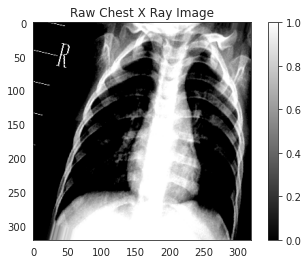

In [9]:
sns.set_style('white')
generated_image, label = train.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

Text(0, 0.5, '# Pixels in Image')

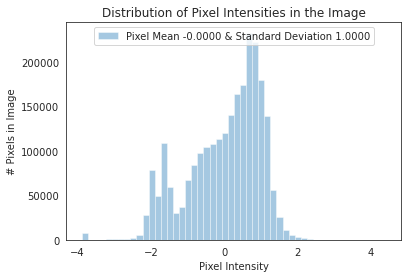

In [10]:
sns.distplot(generated_image.ravel(),
             label=f"Pixel Mean {np.mean(generated_image):.4f} & Standard Deviation {np.std(generated_image):.4f}", 
             kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

# 🤖 Model Building

> One of the challenges with working with medical diagnostic datasets is the large class imbalance present in such datasets.

## ✔️ Impact of imbalance data on loss function

> Loss Function:
$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

> We can rewrite the the overall average cross-entropy loss over the entire training set `D` of size `N` as follows:
$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$



> When we have an imbalance data, using a normal loss function will result a model that bias toward the dominating class. One solution is to use a weighted loss function. Using weighted loss function will balance the contribution in the loss function.

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

In [11]:
# Class weights

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.74
Weight for class 1: 0.26


In [12]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(320, 320, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(320, 320, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

2023-01-31 22:35:22.843995: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 22:35:22.940223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 22:35:22.941042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 22:35:22.942947: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 318, 318, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 318, 318, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 316, 316, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 316, 316, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 158, 158, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 156, 156, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 156, 156, 64)      2

In [14]:
r = model.fit(
    train, 
    epochs=10,
    validation_data=validation, 
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

2023-01-31 22:35:26.655879: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2023-01-31 22:35:28.867264: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


100/100 [==============================] - 45s 361ms/step - loss: 2.9320 - accuracy: 0.7912 - val_loss: 45.6578 - val_accuracy: 0.5000
Epoch 2/10
100/100 [==============================] - 35s 343ms/step - loss: 0.6780 - accuracy: 0.8575
Epoch 3/10
100/100 [==============================] - 33s 330ms/step - loss: 0.3268 - accuracy: 0.8238
Epoch 4/10
100/100 [==============================] - 33s 330ms/step - loss: 0.2031 - accuracy: 0.8725
Epoch 5/10
100/100 [==============================] - 32s 318ms/step - loss: 0.2651 - accuracy: 0.8338
Epoch 6/10
100/100 [==============================] - 32s 316ms/step - loss: 0.1459 - accuracy: 0.8475
Epoch 7/10
100/100 [==============================] - 31s 306ms/step - loss: 0.1777 - accuracy: 0.8150
Epoch 8/10
100/100 [==============================] - 31s 313ms/step - loss: 0.1795 - accuracy: 0.8338
Epoch 9/10
100/100 [==============================] - 29s 290ms/step - loss: 0.1270 - accuracy: 0.8750
Epoch 10/10
100/100 [====================

Text(0.5, 1.0, 'Accuracy Evolution')

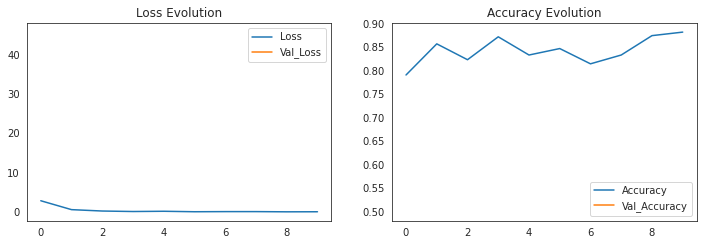

In [15]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [16]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 24s 39ms/step - loss: 5.5705 - accuracy: 0.6426
Test Accuracy: 64.26%
652/652 [==============================] - 184s 282ms/step - loss: 1.4826 - accuracy: 0.7906
Train Accuracy: 79.06%


In [17]:
pred = model.predict(test)

print(confusion_matrix(test.classes, pred > 0.5))
pd.DataFrame(classification_report(test.classes, pred > 0.5, output_dict=True))

[[ 12 222]
 [  0 390]]


,0,1,accuracy,macro avg,weighted avg
precision,1.000000,0.637255,0.644231,0.818627,0.773284
recall,0.051282,1.000000,0.644231,0.525641,0.644231
f1-score,0.097561,0.778443,0.644231,0.438002,0.523112
support,234.000000,390.000000,0.644231,624.000000,624.000000


In [18]:
print(confusion_matrix(test.classes, pred > 0.7))
pd.DataFrame(classification_report(test.classes, pred > 0.7, output_dict=True))

[[ 20 214]
 [  1 389]]


,0,1,accuracy,macro avg,weighted avg
precision,0.952381,0.645108,0.655449,0.798744,0.760335
recall,0.085470,0.997436,0.655449,0.541453,0.655449
f1-score,0.156863,0.783484,0.655449,0.470174,0.548501
support,234.000000,390.000000,0.655449,624.000000,624.000000


# DenseNet

> Densenet is a convolutional network where each layer is connected to all other layers that are deeper in the network:
> - The first layer is connected to the 2nd, 3rd, 4th etc.
> - The second layer is conected to the 3rd, 4th, 5th etc.

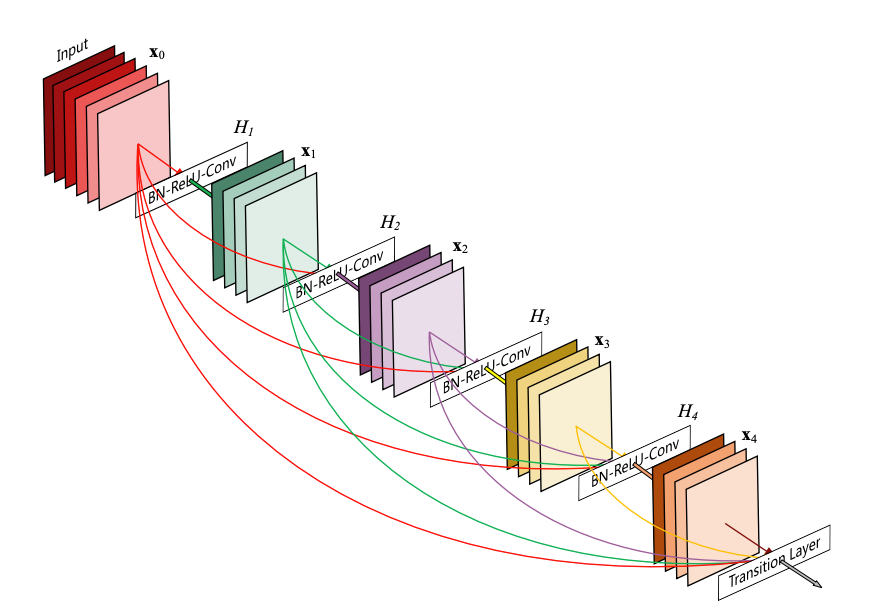

In [19]:
base_model = DenseNet121(input_shape=(320, 320, 3), include_top=False, weights='imagenet', pooling='avg')

base_model.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 326, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 160, 160, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 160, 160, 64) 256         conv1/conv[0][0]                 
_______________________

In [20]:
layers = base_model.layers
print(f"The model has {len(layers)} layers")

print(f"The input shape {base_model.input}")
print(f"The output shape {base_model.output}")

The model has 428 layers
The input shape KerasTensor(type_spec=TensorSpec(shape=(None, 320, 320, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
The output shape KerasTensor(type_spec=TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), name='avg_pool/Mean:0', description="created by layer 'avg_pool'")


In [21]:
# model = Sequential()
base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
# model.add(base_model)
# model.add(GlobalAveragePooling2D())
# model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

r = model.fit(
    train, 
    epochs=10,
    validation_data=validation,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10
100/100 [==============================] - 46s 340ms/step - loss: 0.1405 - accuracy: 0.8338 - val_loss: 3.6415 - val_accuracy: 0.7500
Epoch 2/10
100/100 [==============================] - 31s 310ms/step - loss: 0.1073 - accuracy: 0.8875
Epoch 3/10
100/100 [==============================] - 34s 334ms/step - loss: 0.1119 - accuracy: 0.8913
Epoch 4/10
100/100 [==============================] - 32s 323ms/step - loss: 0.0809 - accuracy: 0.9150
Epoch 5/10
100/100 [==============================] - 32s 319ms/step - loss: 0.0832 - accuracy: 0.9050
Epoch 6/10
100/100 [==============================] - 32s 322ms/step - loss: 0.0850 - accuracy: 0.9162
Epoch 7/10
100/100 [==============================] - 32s 322ms/step - loss: 0.0861 - accuracy: 0.9087
Epoch 8/10
100/100 [==============================] - 32s 316ms/step - loss: 0.1492 - accuracy: 0.8525
Epoch 9/10
100/100 [==============================] - 32s 317ms/step - loss: 0.0860 - accuracy: 0.8988
Epoch 10/10
100/100 [==========

Text(0.5, 1.0, 'Accuracy Evolution')

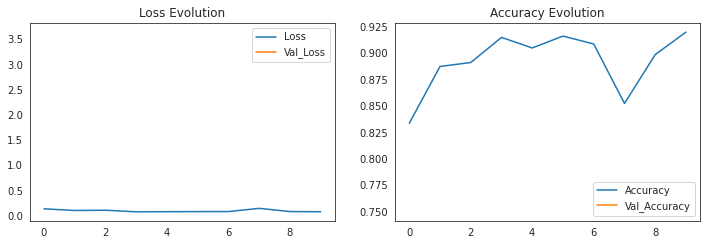

In [22]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [23]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 29s 46ms/step - loss: 1.2132 - accuracy: 0.6058
Test Accuracy: 60.58%
652/652 [==============================] - 185s 284ms/step - loss: 1.5484 - accuracy: 0.5470
Train Accuracy: 54.70%


# Evaluation

In [24]:
predicted_vals = model.predict(test, steps=len(test))

In [25]:
print(confusion_matrix(test.classes, predicted_vals > 0.5))
pd.DataFrame(classification_report(test.classes, predicted_vals > 0.5, output_dict=True))

[[207  27]
 [243 147]]


,0,1,accuracy,macro avg,weighted avg
precision,0.460000,0.844828,0.567308,0.652414,0.700517
recall,0.884615,0.376923,0.567308,0.630769,0.567308
f1-score,0.605263,0.521277,0.567308,0.563270,0.552772
support,234.000000,390.000000,0.567308,624.000000,624.000000


In [26]:
print(confusion_matrix(test.classes, predicted_vals > 0.7))
pd.DataFrame(classification_report(test.classes, predicted_vals > 0.7, output_dict=True))

[[217  17]
 [271 119]]


,0,1,accuracy,macro avg,weighted avg
precision,0.444672,0.875000,0.538462,0.659836,0.713627
recall,0.927350,0.305128,0.538462,0.616239,0.538462
f1-score,0.601108,0.452471,0.538462,0.526790,0.508210
support,234.000000,390.000000,0.538462,624.000000,624.000000
